In [1]:
!unzip 'hw4.zip'

Archive:  hw4.zip
  inflating: HW4.tex                 
  inflating: backprop_example1.txt   
  inflating: backprop_example2.txt   
   creating: datasets/
  inflating: datasets/hw3_cancer.csv  
  inflating: datasets/hw3_house_votes_84.csv  
  inflating: datasets/hw3_wine.csv   
   creating: figures/
  inflating: figures/.DS_Store       
  inflating: figures/network_example.pdf  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


#The 1984 United States Congressional Voting Dataset

The goal, here, is to predict the
party (Democrat or Republican) of each U.S. House of Representatives Congressperson. The dataset is
composed of 435 instances. Each instance is described by 16 categorical attributes, and there are 2 classes.

In [4]:
voting_dataset = pd.read_csv('datasets/hw3_house_votes_84.csv')
voting_dataset = voting_dataset.sample(frac=1, random_state=42)
voting_features = voting_dataset.drop('class', axis=1)
voting_labels = voting_dataset['class']
feature_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
voting_features_encoded = feature_encoder.fit_transform(voting_features)
label_encoder = OneHotEncoder(sparse=False)
voting_labels_encoded = label_encoder.fit_transform(voting_labels.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(voting_features_encoded, voting_labels_encoded, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [6]:
voting_features_encoded.shape[1]

48

In [8]:
nn = NN([voting_features_encoded.shape[1], 4, 8, 2], use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=20000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 98.28%
Testing Accuracy: 94.25%


In [9]:
structures = [
    ([voting_features_encoded.shape[1], 8, 2], 0.01, 0.05),
    ([voting_features_encoded.shape[1], 8, 2], 0.01, 0.1),
    ([voting_features_encoded.shape[1], 16, 2], 0.05, 0.05),
    ([voting_features_encoded.shape[1], 16, 2], 0.05, 0.1),
    ([voting_features_encoded.shape[1], 4, 4, 4, 2], 0.1, 0.05),
    ([voting_features_encoded.shape[1], 4, 4, 4, 2], 0.1, 0.1),
    ([voting_features_encoded.shape[1], 8, 8, 8, 2], 0.05, 0.05),
    ([voting_features_encoded.shape[1], 8, 8, 8, 2], 0.05, 0.1),
    ([voting_features_encoded.shape[1], 16, 16, 16, 2], 0.01, 0.05),
    ([voting_features_encoded.shape[1], 16, 16, 16, 2], 0.01, 0.1),
    ([voting_features_encoded.shape[1], 32, 32, 32, 32, 2], 0.05, 0.05),
    ([voting_features_encoded.shape[1], 32, 32, 32, 32, 2], 0.05, 0.5)
]

results = []

label_classes = np.argmax(voting_labels_encoded, axis=1)

for config, lambda_reg, learning_rate in structures:
    train_accuracies = []
    train_f1_scores = []
    test_accuracies = []
    test_f1_scores = []
    splits = stratified_cross_validation(voting_features_encoded, label_classes, k=10)
    for train_indices, test_indices in splits:
        X_train, y_train = voting_features_encoded[train_indices], voting_labels_encoded[train_indices]
        X_test, y_test = voting_features_encoded[test_indices], voting_labels_encoded[test_indices]
        nn = NN(config, eta=learning_rate, reg_lambda=lambda_reg, use_softmax=True)
        trained_weights = nn.train(X_train, y_train, iterations=10000)
        train_predictions = nn.predict(X_train)
        train_accuracy = accuracy(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions)
        test_predictions = nn.predict(X_test)
        test_accuracy = accuracy(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        test_accuracies.append(test_accuracy)
        test_f1_scores.append(test_f1)
    results.append({
        "configuration": config,
        "lambda": lambda_reg,
        "learning_rate": learning_rate,
        "train_accuracy": np.mean(train_accuracies),
        "train_f1": np.mean(train_f1_scores),
        "test_accuracy": np.mean(test_accuracies),
        "test_f1": np.mean(test_f1_scores)
    })

for result in results:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")


Structure: [48, 8, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 97.93, Train F1: 97.82, Test Acc: 96.54, Test F1: 96.36
Structure: [48, 8, 2], Lambda: 0.01, Learning Rate: 0.1, Train Acc: 98.14, Train F1: 98.03, Test Acc: 95.88, Test F1: 95.63
Structure: [48, 16, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 97.60, Train F1: 97.47, Test Acc: 95.87, Test F1: 95.67
Structure: [48, 16, 2], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 97.52, Train F1: 97.39, Test Acc: 96.06, Test F1: 95.86
Structure: [48, 4, 4, 4, 2], Lambda: 0.1, Learning Rate: 0.05, Train Acc: 61.38, Train F1: 38.03, Test Acc: 61.38, Test F1: 38.03
Structure: [48, 4, 4, 4, 2], Lambda: 0.1, Learning Rate: 0.1, Train Acc: 61.38, Train F1: 38.03, Test Acc: 61.38, Test F1: 38.03
Structure: [48, 8, 8, 8, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 61.38, Train F1: 38.03, Test Acc: 61.38, Test F1: 38.03
Structure: [48, 8, 8, 8, 2], Lambda: 0.05, Learning Rate: 0.1, Train Acc: 61.38, Train F1: 38.03, Test Acc: 61

In [10]:
results_table = pd.DataFrame(results)
results_table = results_table.rename(columns={
    "configuration": "Structure",
    "lambda": "Lambda",
    "learning_rate": "Learning Rate",
    "train_accuracy": "Train Accuracy",
    "train_f1": "Train F1 Score",
    "test_accuracy": "Test Accuracy",
    "test_f1": "Test F1 Score"
})
results_table.sort_values(by=["Lambda", "Learning Rate"], inplace=True)
print(results_table.to_string(index=False))

              Structure  Lambda  Learning Rate  Train Accuracy  Train F1 Score  Test Accuracy  Test F1 Score
             [48, 8, 2]    0.01           0.05       97.930863       97.821630      96.542334      96.356611
    [48, 16, 16, 16, 2]    0.01           0.05       92.844278       90.341181      91.780429      89.260237
             [48, 8, 2]    0.01           0.10       98.135402       98.034964      95.876623      95.632800
    [48, 16, 16, 16, 2]    0.01           0.10       98.825158       98.759156      95.854978      95.633675
            [48, 16, 2]    0.05           0.05       97.598838       97.472029      95.866053      95.665518
       [48, 8, 8, 8, 2]    0.05           0.05       61.379342       38.034196      61.382009      38.034893
[48, 32, 32, 32, 32, 2]    0.05           0.05       61.379342       38.034196      61.382009      38.034893
            [48, 16, 2]    0.05           0.10       97.522047       97.391888      96.055321      95.862488
       [48, 8, 8, 8

### Vectorized form of backpropagation and forward.

**Question 4** Discuss (on a high level) what contributed the most to improving performance: changing the
regularization parameter; adding more layers; having deeper networks with many layers but few
neurons per layer? designing networks with few layers but many neurons per layer? Discuss any
patterns that you may have encountered. Also, discuss whether there is a point where constructing
and training more “sophisticated”/complex networks—i.e., larger networks—no longer improves
performance (or worsens performance).

I used number of k=10000 iterations as stopping criterion.

The architectures with fewer layers [48, 8, 2] and [48, 16, 2] show higher accuracy and F1 scores compared to much deeper structures [48, 8, 8, 8, 2] or [48, 32, 32, 32, 32, 2]. This suggests that for the given dataset, adding more layers does not necessarily improve performance and might even degrade it.

The architecture [48, 16, 16, 16, 2] shows a decent performance but does not surpass the simpler [48, 8, 2] or [48, 16, 2] structures. It implies that a moderate increase in depth and neurons can be beneficial but up to a certain point.

Regularization: The lambda value used 0.01 and 0.05 does not show drastic differences in the simpler architectures but does affect the more complex ones, suggesting that simpler networks are less sensitive to changes in regularization. Higher regularization might prevent overfitting in deeper networks but also could hinder learning due to too much penalty on the weights.

A higher learning rate 0.10 compared to 0.05 does not consistently improve or worsen the performance across different architectures. However, the simpler models seem to slightly benefit from the higher learning rate, indicating they are stable enough to handle faster learning without diverging.

Networks with many layers but fewer neurons [48, 8, 8, 8, 2] and deeper variants consistently show much poorer performance compared to other architectures. This suggests that just adding layers without sufficient neurons per layer does not capture the complexity of the data well and might be leading to issues like vanishing gradients or insufficient model capacity.

There seems to be a point where adding more complexity to the network (more layers, neurons etc..) no longer yields better performance and might even worsen it. This is evident from the consistently low performance of the deepest architectures tested, irrespective of other hyperparameters.The point of diminishing returns occurs moving from the [13, 16, 16, 16, 3] structure to the [13, 32, 32, 32, 32, 3] structure. While the former still holds reasonable performance, the latter shows a decline in effectiveness, indicating that it's counterproductive.

Optimal Performance seems to be achieved with moderate complexity in the network architecture.

**Question 5** Based on the analyses above, discuss which neural network architecture you would select if you had
to deploy such a classifier in real life. Explain your reasoning


Based on the performance data and the analysis of various neural network architectures tested, we're going to discuss what model we would select for real-life deployment.
I would choose [48, 8, 2] since this architecture consistently showed high accuracy and F1 scores, demonstrating its ability to effectively learn and generalize from the dataset without overfitting. It maintained a high level of performance across different learning rates and regularization parameters, suggesting robustness in various training scenarios. With fewer layers, this model is computationally less demanding than deeper networks. This simplicity will likely translate to faster training times and lower computational costs, which are crucial factors for real-world applications. Deeper networks, such as those with multiple hidden layers containing numerous neurons, tended to perform worse in this case, likely due to overfitting etc. The selected architecture is a safer choice for deployment.

A lambda value of 0.01 and a learning rate of 0.05 or 0.10 seem to be effective based on the performance metrics.

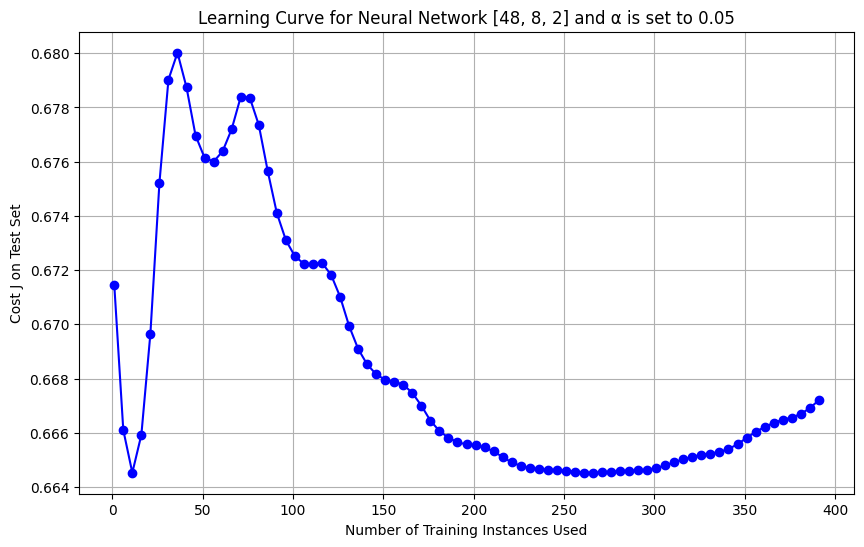

In [17]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=5):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs

np.random.seed(0)
nn = NN([48, 8, 2], eta=0.05, reg_lambda=0.01, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 5), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [48, 8, 2] and α is set to 0.05')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)
plt.show()

α is set to 0.05